# 1. Import the required libraries

In [1]:
import matplotlib.pyplot as plt #Libraries for visualization
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np #Library for numerical calculations
from scipy import stats #Library for statistical analysis 
from sklearn import datasets #Libraries for machine learning
from sklearn.naive_bayes import GaussianNB 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
%matplotlib notebook

# 2. Load the Iris Dataset

First we need to load the dataset. As one of the standard ML datasets, the Iris dataset is already uploaded to the Scikit-learn library and we can just load it using a function. For most datasets however, we will probably need to read from a file (such as a .csv).

Here we also need to start gaining knowledge of our dataset, first by quantifying the amount of data and features we have.

In [29]:
iris = datasets.load_iris()
X = iris.data #The X matrix corresponds to the input vectors, where every row corresponds to a data point (a flower in this case), and every column corresponds to a feature (such as sepal length)
y = iris.target #The y vector corresponds to the output values, where the i'th value is the class of the i'th feature vector (row) in X

target_names = iris.target_names
feature_names = iris.feature_names

number_of_features = X.shape[1]
number_of_classes = len(np.unique(y))

print("Number and names of classes:", len(np.unique(y)), target_names) #The number of classes is the number of unique values of the y vector
print("Number and names of features:", X.shape[1], feature_names) #The number of features is equal to the amount of columns in the X matrix
print("Number of data points:", X.shape[0]) #The number of datapoints is equal to the amount of rows in the X matrix

Number and names of classes: 3 ['setosa' 'versicolor' 'virginica']
Number and names of features: 4 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of data points: 150


In the normal case, this is one way of loading a dataset. This is the case when the first row represents the column names, the last column represents class and when the data is float and class are integers. In other cases we have to adjust the code depending on what we have.

In [9]:
# column_names = np.loadtxt(open("dataset_name.csv", "rb"), delimiter=",", max_rows=1, dtype = str) #The first row usually represents the column names so we can read them like this
# data = np.loadtxt(open("dataset_name.csv", "rb"), delimiter=",", skiprows=1, dtype = str) #We get the remaining rows as the data
# X = data[:,:-1].astype(np.float) #We split the data to the input vectors (every column except the last one which usually represents the class) (note that all the data aren't always float so we have to cast them in a different way)
# y = data[:,-1].astype(np.int) #We get the last column of the data as the target classes
# print(X.shape)
# print(y.shape)

(303, 13)
[ 63.    1.    3.  145.  233.    1.    0.  150.    0.    2.3   0.    0.
   1. ]
(303,)


# 3. Visualizations

To know what models to apply, what assumptions to make, what hypotheses to test on our dataset, we need to first gain some intuitive knowledge of the data. This consists of multiple steps, with maybe the most important one being visualization, which we will focus on here. 

We start with visualizing the histogram of each feature and the scatterplots of each feature pair. 

Then we test and visualize the dependence of every feature pair with some metric (Pearson's correlation coefficient is used here). 

We can also visualize the dataset into a lower dimensional set (2D, 3D) which allows a full visualization of the data using a dimensionality reduction technique such as LDA or PCA (which we will study in a few classes).

In [81]:
#Setting plotting parameters, not usually needed (we can go with default values)
colors = ['navy', 'turquoise', 'darkorange']

### 3.1 Whole data Histograms and within class Histograms 
You can see the function which we use to plot these histograms here: https://seaborn.pydata.org/generated/seaborn.distplot.html
The line shown in each of these histogram represents the KDE (Kernel density estimate) which is only an estimation of the distribution from the data.

<IPython.core.display.Javascript object>


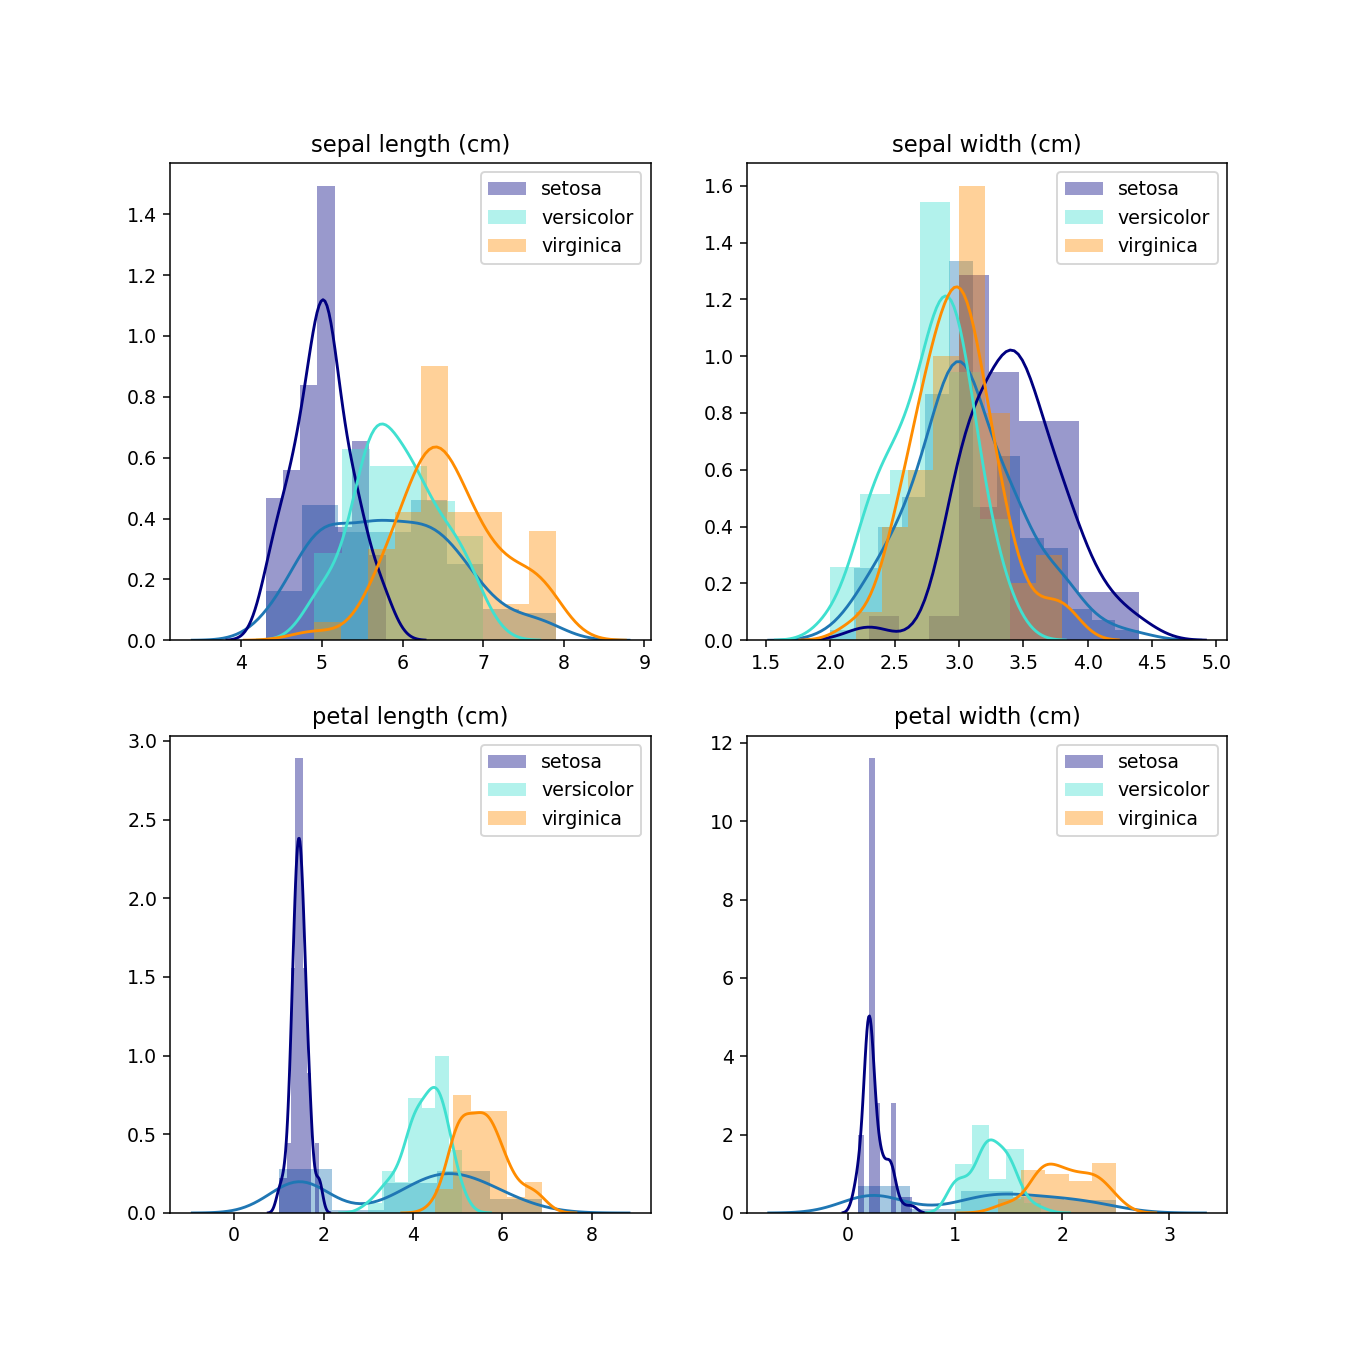

In [84]:
fig = plt.figure(figsize=(10, 10))
fig.subplots(nrows=2, ncols=2)
for feat_i in range(number_of_features): #For each feature, we have a new subplot
    ax = plt.subplot(2,2, feat_i+1)
    plt.title(feature_names[feat_i]) 
    sns.distplot(X[:,feat_i]) #Once we have a specific feature, we draw the histogram of the feature's data (X[:,i] means we get the i'th column of X)
    for class_i in range(number_of_classes): #After that we draw the within-class histograms of the same feature
        sns.distplot(X[y == class_i,feat_i], color=colors[class_i], label=target_names[class_i]) # (X[y==c,i] means we get the i'th column of X where the class in the same row in y is equal to c
    plt.legend()
plt.show()

### 3.2 Feature scatterplots. 
The scatterplot represents each data point on a 2 Dimensional space where each axis represents a feature. 
Therefore we need one scatterplot for each pair of features leading to DxD scatterplots (where D is the number of features). Typically we don't have to do all the scatterplots, only for the features which give higher information in the classification task (we will study this onward).
More info about the function we use to plot this here: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html

<IPython.core.display.Javascript object>


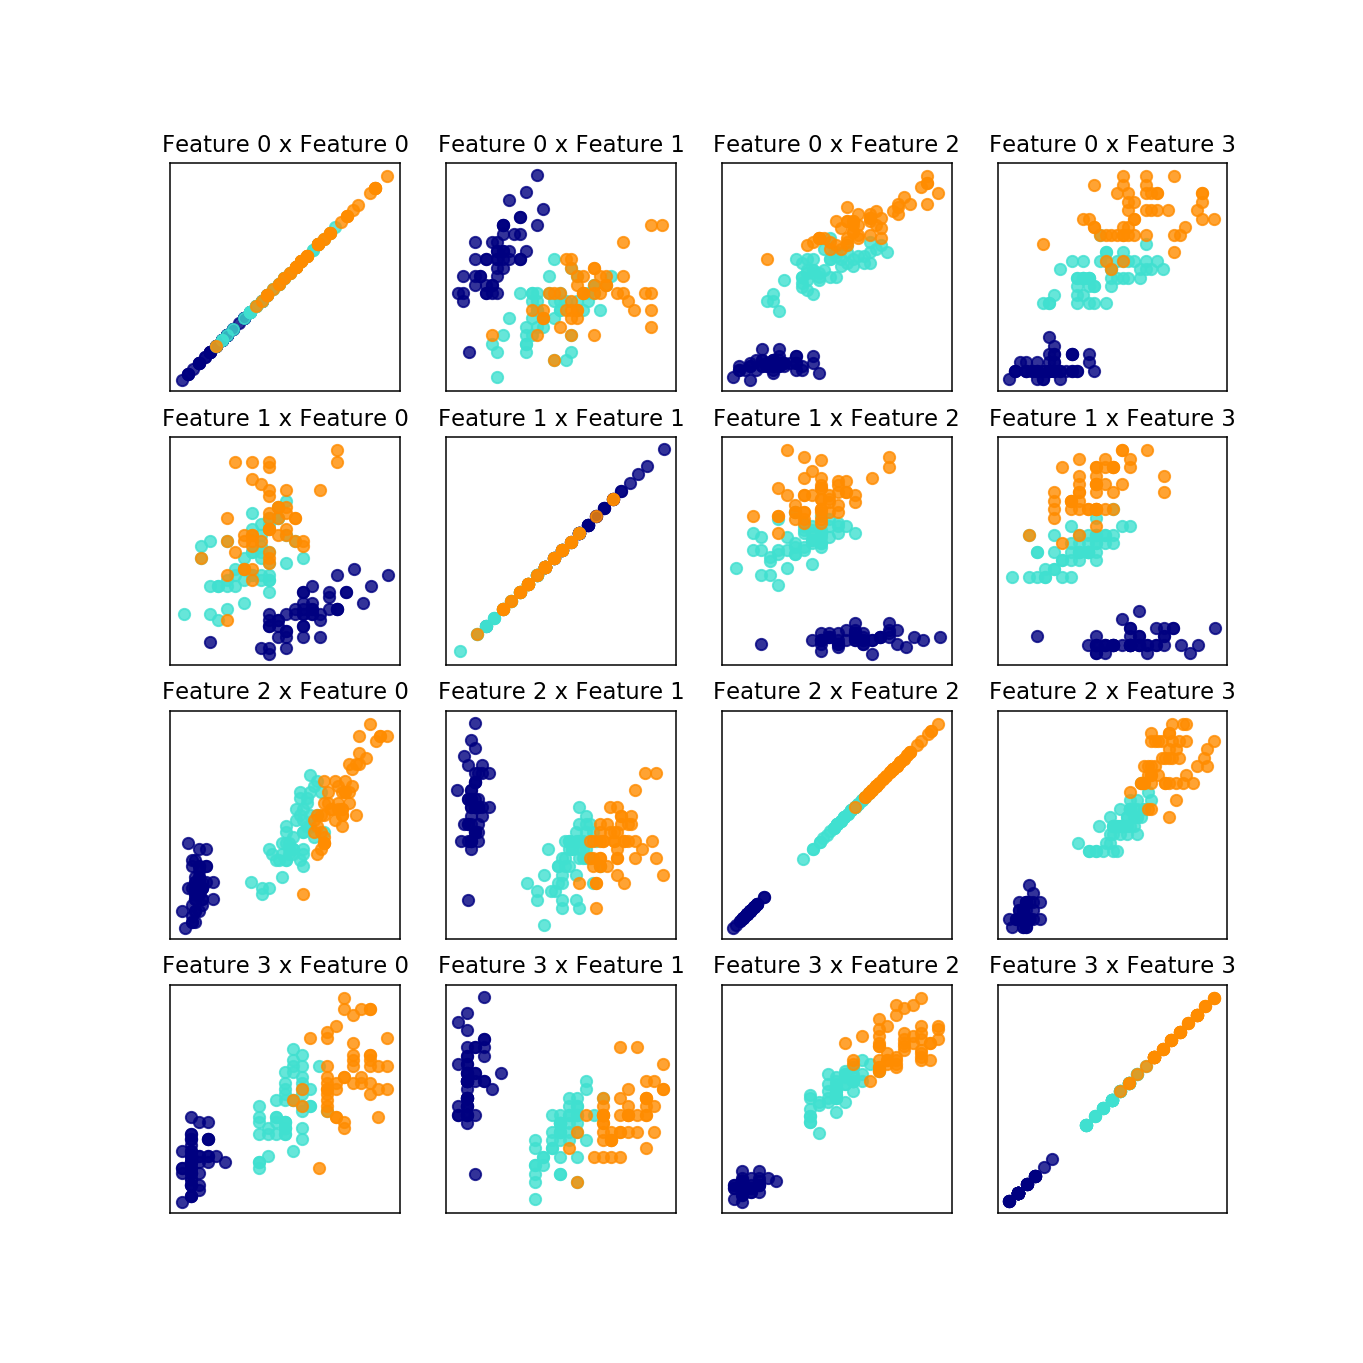

In [85]:
fig = plt.figure(figsize=(10, 10))
plt.title("Scatterplots of the IRIS dataset features")
fig.subplots(nrows=4, ncols=4)
for feat_i in range(number_of_features): #We go over all pairs of features (4x4 in this case)
    for feat_j in range(number_of_features):  
        ax = plt.subplot(4,4,number_of_features*feat_i + feat_j+1)
        # Plot the points
        for color, i, target_name in zip(colors, [0, 1, 2], target_names):
            plt.scatter(X[y == i, feat_i], X[y == i, feat_j], alpha=.8, color=color, label=target_name) #We again extract the feature class specific data using the same method as before and then just use the scatter function
        plt.xticks(())
        plt.yticks(())
        plt.title("Feature "+str(feat_i)+" x Feature "+str(feat_j))
plt.show()

### 3.3 Between feature dependence
Since we have seen through the scatterplots visually how these features are mutually dependent, we can now also calculate it using some metric. The metric we will use here is Person's correlation coefficient, however more complex metrics are available. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

<IPython.core.display.Javascript object>


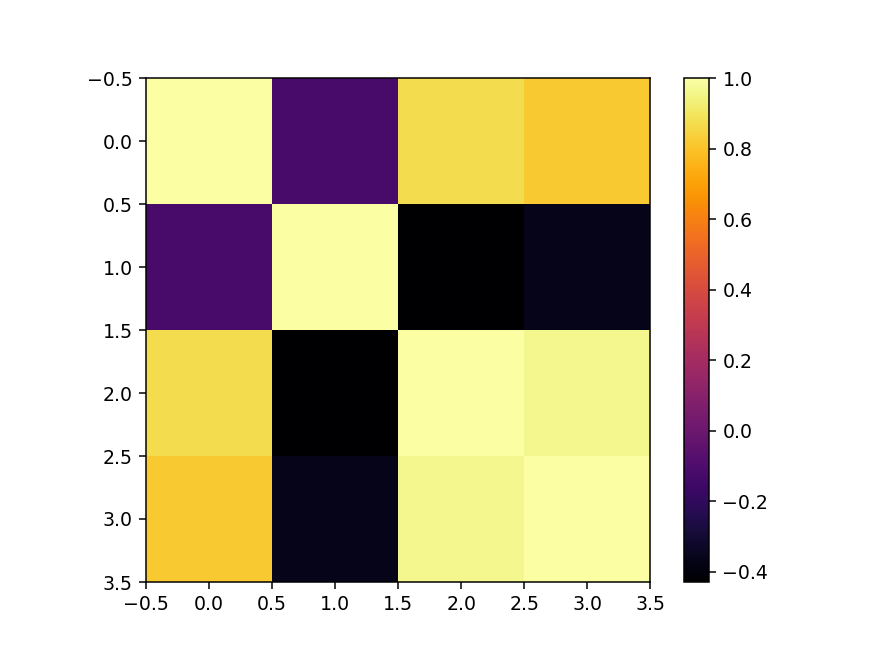

In [87]:
correlation_matrix = np.zeros((number_of_features,number_of_features))
for i in range(number_of_features): #We need a 4x4 matrix to represent the correlation matrix, where we set the value of Cij to be the correlation between the i'th and the j'th metric
    measure = X[:,i]
    for j in range(number_of_features):
        measure2 = X[:,j]
        corr, _ = stats.pearsonr(measure, measure2)
        correlation_matrix[i][j] = corr
plt.figure()
plt.imshow(correlation_matrix, cmap = "inferno") #We can draw the matrix using imshow
plt.colorbar()
plt.show()

### 3.4 PCA  (*This section won't be necessary for the first laboratory assignment*)
To transform the data into a 3 dimensional space for visualization we can use PCA. However this is not applicable on all datasets, especially when the number of features is a lot larger than 3, since we cannot approximate the variance of the features with 3 principal components. (We will study this later on in the class)
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html



<IPython.core.display.Javascript object>


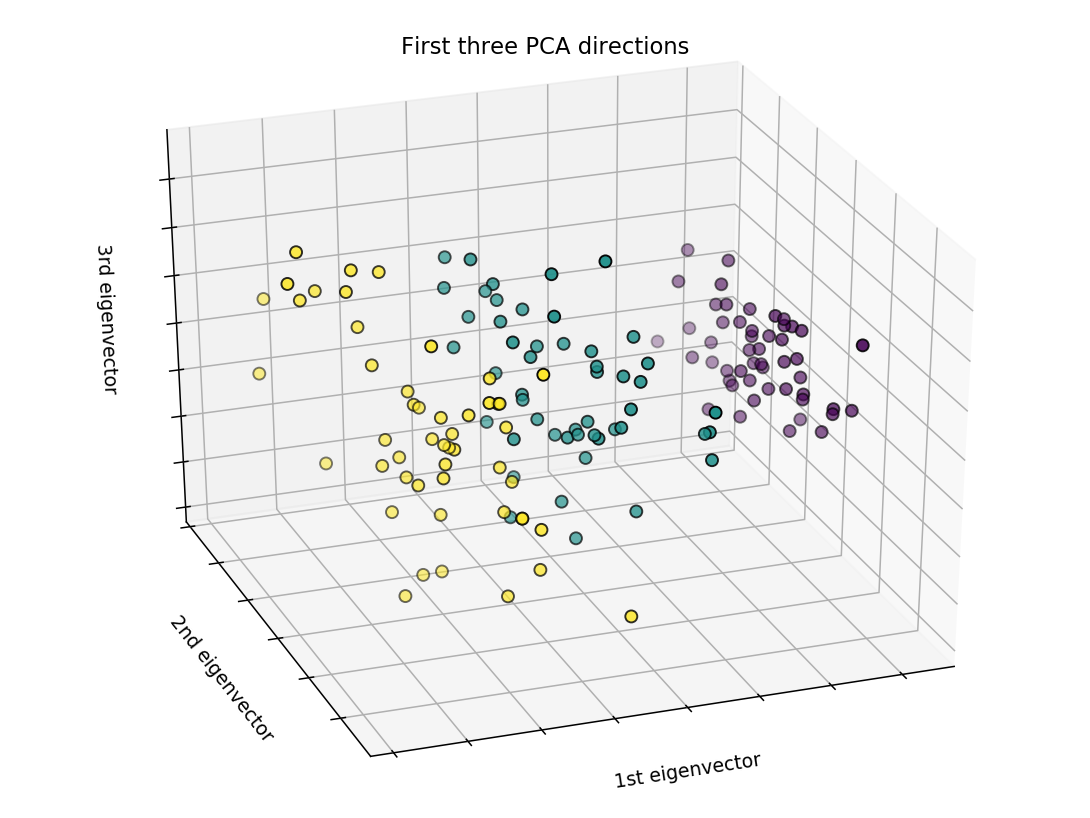

In [91]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

pca = PCA(n_components=3) #We set the number of components to 3 so we can transform to a 3D space
X_reduced = pca.fit(X).transform(X) # Now we fit the PCA model to X with fit() and apply it to X immediately with transform() 
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.show()

<IPython.core.display.Javascript object>


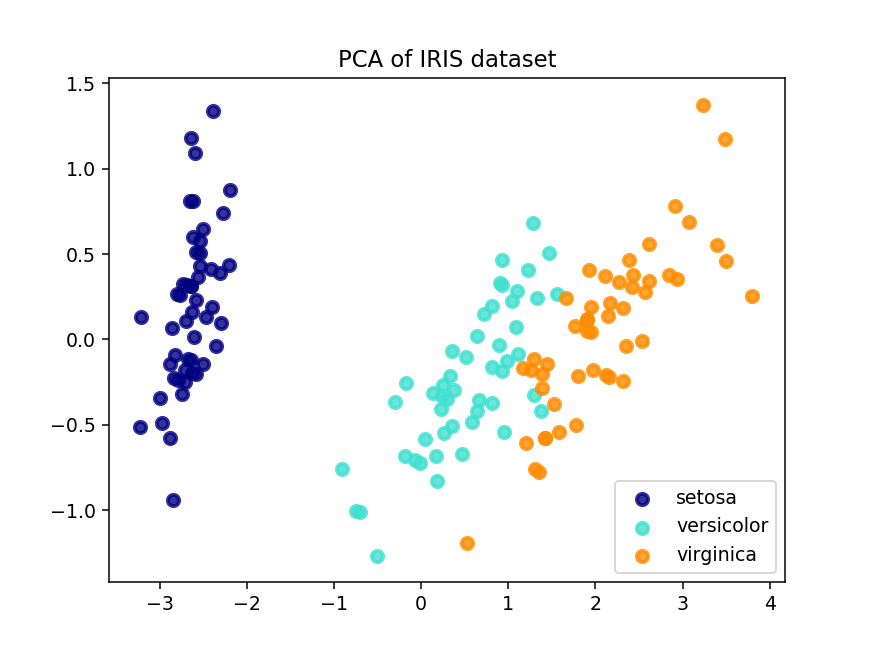

In [92]:
pca = PCA(n_components=2) #We set the number of components to 2 so we can transform to a 2D space
X_PCA = pca.fit(X).transform(X) # We again fit the PCA model to X with fit() and apply it to X immediately with transform() 

plt.figure() #Since we only have 2 dimensions we can now draw the data to a 2D space using the same method from above (scatter)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_PCA[y == i, 0], X_PCA[y == i, 1], color=color, alpha=.8, lw=2,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')
plt.show()

### 3.5 LDA dimensionality reduction

We can also use LDA to transform the data. As we learned, LDA can be used to transform the data to a C-1 dimensional space(where C is the number of classes). However scikit-learns implementation allows to choose any number of components (and not just C-1) as it uses a combined implementation of LDA and PCA.

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis

<IPython.core.display.Javascript object>


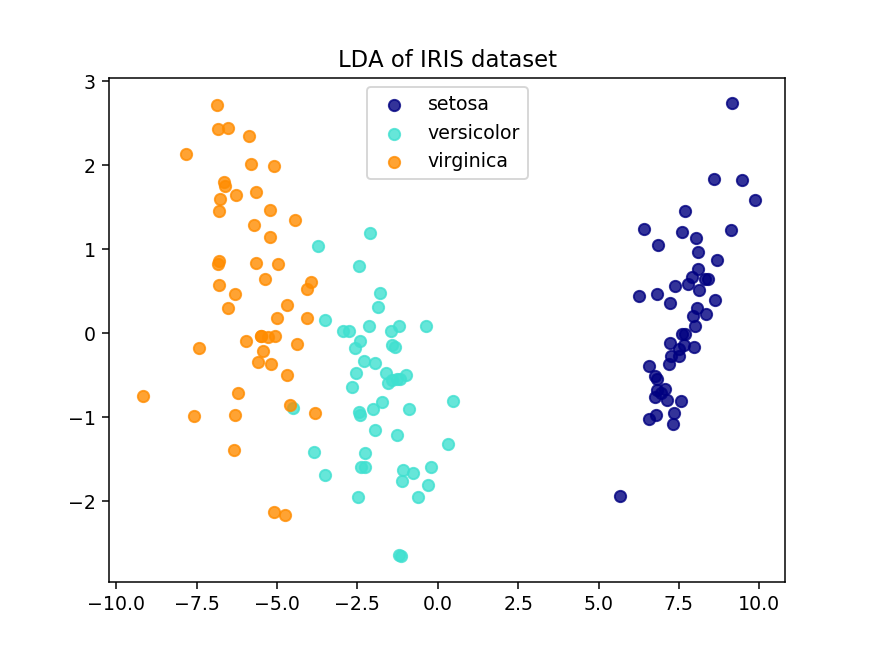

Text(0.5, 1.0, 'LDA of IRIS dataset')

In [93]:
lda = LinearDiscriminantAnalysis(n_components=2) #We set the number of components to 2 so we can transform to a 2D space
X_LDA = lda.fit(X, y).transform(X) # We fit the LDA model to X,y with fit() and apply it to X immediately with transform() 
#Note that in LDA, we also give class information when fitting the model since it is a supervised method unlike PCA
plt.figure() #We can again draw the data to a 2D space
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_LDA[y == i, 0], X_LDA[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

# 4. Classification

### 4.1 Splitting the dataset to a training and test set
Once we have some intuition of the data we can start building the classifiers and testing the accuracy. 
First we need to split the data to a training set and a test set. Since the number of datapoints to number of feature ratio is large in this dataset, we can just use 70% of the original data as training data and the remaining 30% as test data. In other datasets where the number of data points is low, we can use techniques such as Cross Validation.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) #We split the original dataset (we use a fixed random state such as 42 so we always split the data the same way)
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.30, random_state=42) #We split the PCA dimensionaly reducted dataset
X_LDA_train, X_LDA_test, y_LDA_train, y_LDA_test = train_test_split(X_LDA, y, test_size=0.30, random_state=42) #We split the LDA dimensionaly reducted dataset

### 4.2 Classifications on the original dataset

#### 4.2.1 Classification using LDA 
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis

In [95]:
#LDA model
lda = LinearDiscriminantAnalysis() #We initialize the model
lda.fit(X_train, y_train) #We fit the model to the training data X_train and the appropriate class labels y_train
y_pred = lda.predict(X_test) #We get the predictions of the test data X_test using the predict function
accuracy = np.round(np.sum(y_test == y_pred)/len(y_test),3)
#To evaluate the accuracy we need to compute the number_of_correct_predictions/number_of_total_predictions
#y_test == y_pred evaluates where the test set labels y_test are equal to the predictions y_pred and returns a vector of 1 (where they are the same) and 0 (where they are different)
#np.sum(y_test == y_pred) just computes the sum of these 1's and 0's giving the total number of correct predictions
#Afterwards we divide this sum with the number of test labels: len(y_test) to get the percentage of correct predictions
#Finally we round the accuracy to the 3rd decimal using np.round(np.sum(y_test == y_pred)/len(y_test),3)
print("LDA accuracy for the original Iris dataset", accuracy) 

LDA accuracy for the original Iris dataset 1.0


#### 4.2.2 Classification using Naive Bayes
https://scikit-learn.org/stable/modules/naive_bayes.html

Since this dataset consists of only continuous variables, we can use the Gaussian version of Naive Bayes 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

In [97]:
#Naive Bayes model
#The initialization, fitting, predicting and evaluating accuracy is the same as the lda model
gnb = GaussianNB() 
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy = np.round(np.sum(y_test == y_pred)/len(y_test),3)
print("Naive Bayes accuracy for the original Iris dataset", accuracy)

Naive Bayes accuracy for the original Iris dataset 0.978


### 4.2 Classifications on the PCA transformed dataset   (*This section won't be necessary for the first laboratory assignment*)

Since this data (and the LDA transformed dataset) is in 2D, we can first visualize the test data so we can make some assumptions on what the models will do or what errors we expect due to the nature of the model. 
After classification of each model, we can mark the errors and make sense of what happened. 

<IPython.core.display.Javascript object>


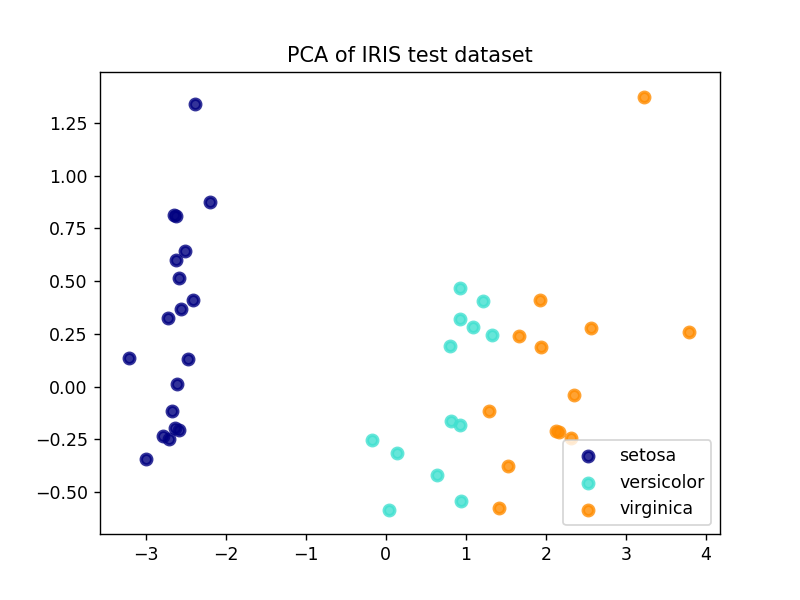

In [98]:
plt.figure() #Here we draw the data in 2D as in the upper image, but we only draw the test data set 
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_PCA_test[y_PCA_test == i, 0], X_PCA_test[y_PCA_test == i, 1], color=color, alpha=.8, lw=2,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS test dataset')
plt.show()

LDA accuracy for the PCA dimensionaly reducted Iris dataset 1.0


<IPython.core.display.Javascript object>


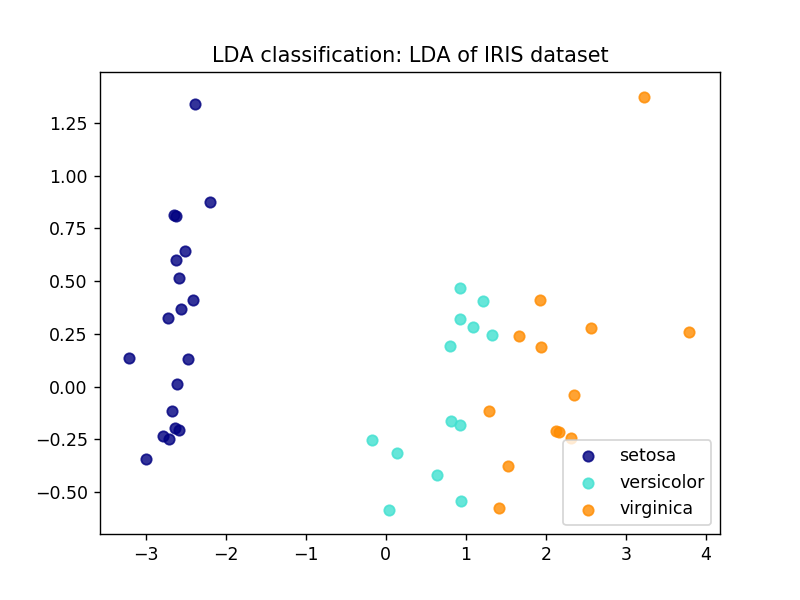

In [101]:
#Initialize the model, fit the training data and predict the test data
lda = LinearDiscriminantAnalysis()
lda.fit(X_PCA_train, y_PCA_train)
y_pred = lda.predict(X_PCA_test)
accuracy = np.round(np.sum(y_PCA_test == y_pred)/len(y_PCA_test),3)
print("LDA accuracy for the PCA dimensionaly reducted Iris dataset", accuracy)

plt.figure() #Draw the data the same way as before
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_PCA_test[y_PCA_test == i, 0], X_PCA_test[y_PCA_test == i, 1], alpha=.8, color=color,
                label=target_name)
plt.title('LDA classification: LDA of IRIS dataset')

#To draw the incorrectly guessed data we first get the same vector y_pred==y_PCA_test where we have True where the prediction was correct and False if not
#Afterwards we just go through the vector and the draw the cases where the value is False 
incorrect = y_pred==y_PCA_test
for i in range(len(incorrect)):
    if(incorrect[i]==False):
        plt.scatter(X_PCA_test[i][0], X_PCA_test[i][1], alpha=.5, color="black")
plt.legend(loc='best', shadow=False, scatterpoints=1)

Naive Bayes accuracy for the PCA dimensionaly reducted Iris dataset 0.889


<IPython.core.display.Javascript object>


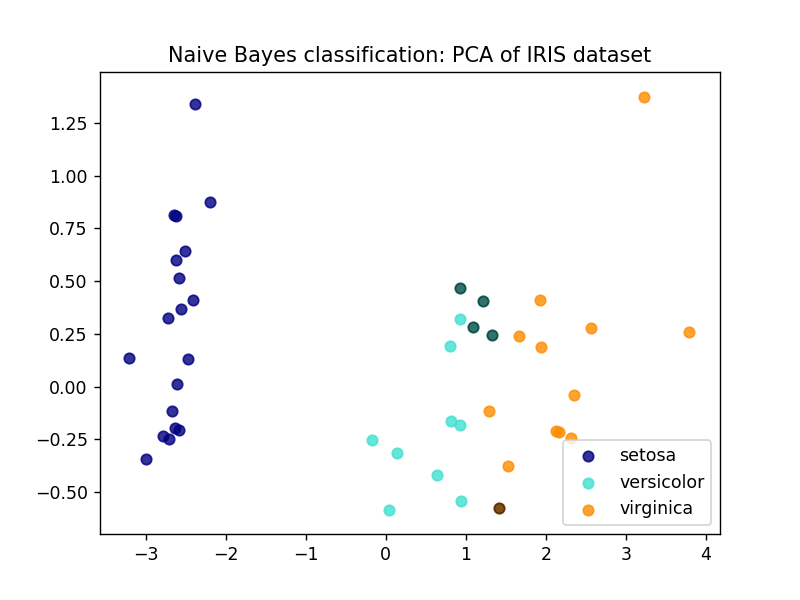

In [75]:
#Initialize the model, fit the training data and predict the test data
gnb = GaussianNB()
gnb.fit(X_PCA_train, y_PCA_train)
y_pred = gnb.predict(X_PCA_test)
print("Naive Bayes accuracy for the PCA dimensionaly reducted Iris dataset", np.round(np.sum(y_PCA_test == y_pred)/len(y_PCA_test),3))

#Visualize the test set and the errors which have occured
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_PCA_test[y_PCA_test == i, 0], X_PCA_test[y_PCA_test == i, 1], alpha=.8, color=color,
                label=target_name)
plt.title('Naive Bayes classification: PCA of IRIS dataset')

incorrect = y_pred!=y_PCA_test
for i in range(len(incorrect)):
    if(incorrect[i]==True):
        plt.scatter(X_PCA_test[i][0], X_PCA_test[i][1], alpha=.5, color="black")
plt.legend(loc='best', shadow=False, scatterpoints=1)

### 4.2 Classifications on the LDA transformed dataset

LDA accuracy for the LDA dimensionaly reducted Iris dataset 1.0


<IPython.core.display.Javascript object>


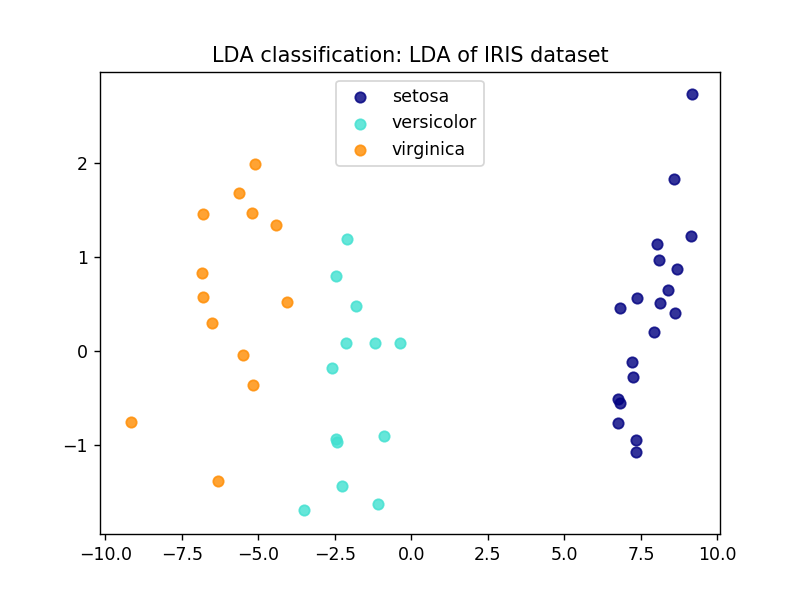

In [71]:
#Initialize the model, fit the training data and predict the test data
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(X_LDA_train, y_LDA_train)
y_pred = lda.predict(X_LDA_test)
print("LDA accuracy for the LDA dimensionaly reducted Iris dataset", np.round(np.sum(y_LDA_test == y_pred)/len(y_LDA_test),3))

#Visualize the test set and the errors which have occured
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_LDA_test[y_LDA_test == i, 0], X_LDA_test[y_LDA_test == i, 1], alpha=.8, color=color,
                label=target_name)
plt.title('LDA classification: LDA of IRIS dataset')

incorrect = y_pred!=y_LDA_test
for i in range(len(incorrect)):
    if(incorrect[i]==True):
        plt.scatter(X_LDA_test[i][0], X_LDA_test[i][1], alpha=.5, color="black")
plt.legend(loc='best', shadow=False, scatterpoints=1)

Naive Bayes accuracy for the LDA dimensionaly reducted Iris dataset 1.0


<IPython.core.display.Javascript object>


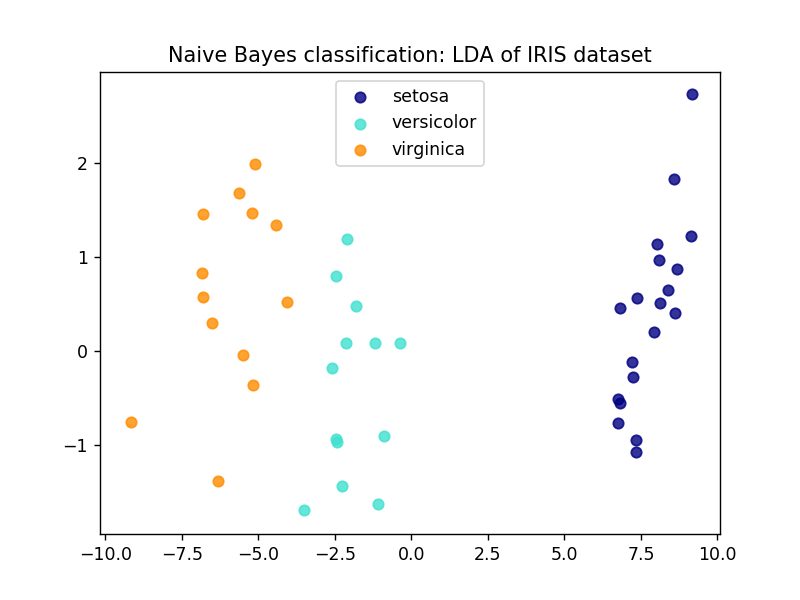

In [74]:
#Initialize the model, fit the training data and predict the test data
gnb = GaussianNB()
gnb.fit(X_LDA_train, y_LDA_train)
y_pred = gnb.predict(X_LDA_test)
print("Naive Bayes accuracy for the LDA dimensionaly reducted Iris dataset", np.round(np.sum(y_LDA_test == y_pred)/len(y_LDA_test),3))

#Visualize the test set and the errors which have occured
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_LDA_test[y_LDA_test == i, 0], X_LDA_test[y_LDA_test == i, 1], alpha=.8, color=color,
                label=target_name)
plt.title('Naive Bayes classification: LDA of IRIS dataset')

incorrect = y_pred!=y_LDA_test
for i in range(len(incorrect)):
    if(incorrect[i]==True):
        plt.scatter(X_LDA_test[i][0], X_LDA_test[i][1], alpha=.5, color="black")
plt.legend(loc='best', shadow=False, scatterpoints=1)

# 5. Playing with Priors

Finally, we play with some prior probabilities in the LDA classificator. As we learned, the prior probability just moves the decision function line towards the class with the higher prior. This may lead to some errors in the classes with lower prior as we can see in the examples below. This can also be done for the Naive Bayes classifier.

LDA accuracy for the PCA dimensionaly reducted Iris dataset 0.956


<IPython.core.display.Javascript object>


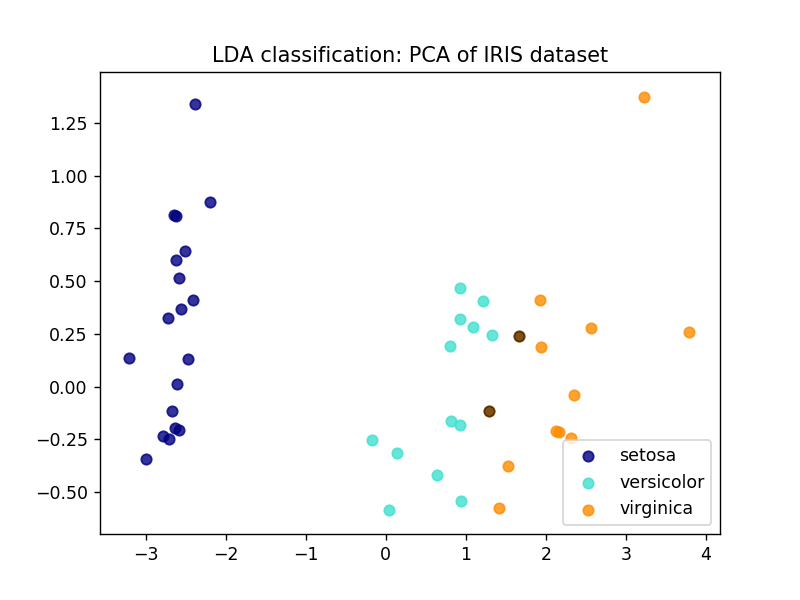

In [76]:
#Adding a higher prior probability to the versicolor class

#Initialize the model, fit the training data and predict the test data
lda = LinearDiscriminantAnalysis(priors = [0.1,0.8,0.1])
lda.fit(X_PCA_train, y_PCA_train)
y_pred = lda.predict(X_PCA_test)
print("LDA accuracy for the PCA dimensionaly reducted Iris dataset", np.round(np.sum(y_PCA_test == y_pred)/len(y_PCA_test),3))

#Visualize the test set and the errors which have occured
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_PCA_test[y_PCA_test == i, 0], X_PCA_test[y_PCA_test == i, 1], alpha=.8, color=color,
                label=target_name)
plt.title('LDA classification: PCA of IRIS dataset')

incorrect = y_pred!=y_PCA_test
for i in range(len(incorrect)):
    if(incorrect[i]==True):
        plt.scatter(X_PCA_test[i][0], X_PCA_test[i][1], alpha=.5, color="black")
plt.legend(loc='best', shadow=False, scatterpoints=1)

LDA accuracy for the PCA dimensionaly reducted Iris dataset 0.956


<IPython.core.display.Javascript object>


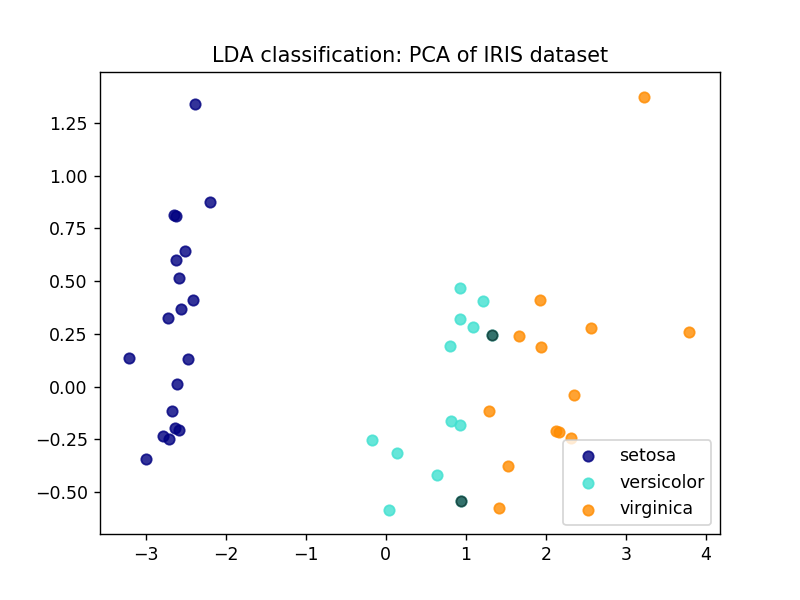

In [77]:
#Adding a higher prior probability to the virginica class

#Initialize the model, fit the training data and predict the test data
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, priors = [0.1,0.1,0.1])
lda.fit(X_PCA_train, y_PCA_train)
y_pred = lda.predict(X_PCA_test)
print("LDA accuracy for the PCA dimensionaly reducted Iris dataset", np.round(np.sum(y_PCA_test == y_pred)/len(y_PCA_test),3))

#Visualize the test set and the errors which have occured
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_PCA_test[y_PCA_test == i, 0], X_PCA_test[y_PCA_test == i, 1], alpha=.8, color=color,
                label=target_name)
plt.title('LDA classification: PCA of IRIS dataset')

incorrect = y_pred!=y_PCA_test
for i in range(len(incorrect)):
    if(incorrect[i]==True):
        plt.scatter(X_PCA_test[i][0], X_PCA_test[i][1], alpha=.5, color="black")
plt.legend(loc='best', shadow=False, scatterpoints=1)